In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import opt_einsum
from scipy.constants import physical_constants
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-1/2, vmax=1/2)
cmap2 = mpl.cm.RdYlBu
norm2 = mpl.colors.Normalize(vmin=-1, vmax=1)

boltzConst = physical_constants["Boltzmann constant in eV/K"][0]

transformationMatrix = np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
spinMatrixZ = 1/2*transformationMatrix @ np.kron(np.diag((1,1,1,1)),np.array([[1.,0.],[0.,-1.]])) @ (transformationMatrix.T.conj())

In [2]:
def createContourGraph(length, Z1,Z2,levels,filename='default'):
    #First we define our plot enviroment and meshgrid
    # want to have the points at + pi and -p to be symmetric
    x = np.linspace(-1,1,length,endpoint=True) + 1/(2*(length+1))
    y = np.linspace(-1,1,length,endpoint=True) + 1/(2*(length+1))
    X, Y = np.meshgrid(x, y, indexing='ij')
    fig, ax = plt.subplots(dpi=100)
    kxVectorPath1 = np.empty(0)
    kxVectorPath2 = np.empty(0)
    kyVectorPath1 = np.empty(0)
    kyVectorPath2 = np.empty(0)
    #Then we loop through all eigenvalues and plot their contours
    for i in range(2):
        try:
            CS1 = ax.contour(X,Y,Z1[:,:,i],levels,colors='black')
            CS2 = ax.contour(X,Y,Z2[:,:,i],levels,colors='gray')
            #ax.clabel(CS, inline=True, fontsize=10)
            c1 = CS1.get_paths()[0]
            v1 = c1.vertices
            kxVectorPath1, kyVectorPath1 = v1[:,0], v1[:,1]
            c2 = CS2.get_paths()[0]
            v2 = c2.vertices
            kxVectorPath2, kyVectorPath2 = v2[:,0], v2[:,1]


        except:
            continue
    ticks = np.array([-1,0.5,0,0.5,1])
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel('$k_x$ [$ \\pi / a$]')
    ax.set_ylabel('$k_y$ [$ \\pi / a$]')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_aspect('equal')
    #fig.savefig('%s.png'%filename)
    fig.savefig('%s.pdf'%filename)
    plt.show()
    plt.close('all')

    # save data points (x,y)
    np.savetxt(f'Fig4_2_N={length}_band1.txt', np.array([kxVectorPath1, kyVectorPath1]))
    np.savetxt(f'Fig4_2_N={length}_band2.txt', np.array([kxVectorPath2, kyVectorPath2]))
    return

def fermi(x,supp=50):
    '''From Andreas Kreisel (Copied from C++ code). Implemented for numpy array with masks
    I use some tricks like not computing the array elements that are zero, implicitly letting them be so, and using the mask array
    True values as the 1's for my Fermi function.
    '''
    resArray = np.zeros_like(x)

    # I only have to set values under support to 1 since values over support are already 0
    maskedArr1 = np.ma.getmaskarray(np.ma.masked_less_equal(x,-supp))
    resArray[maskedArr1] = 1

    # Now calculate Fermi function for negative x
    maskedArr2 = np.ma.getmaskarray(np.ma.masked_where((-supp<x) & (x<=0), x))
    resArray[maskedArr2] = np.exp(-x[maskedArr2]) / (np.exp(-x[maskedArr2]) + 1.)

    # Now calculate Fermi function for positive x
    maskedArr3 = np.ma.getmaskarray(np.ma.masked_where((0<x) & (x<supp), x))
    resArray[maskedArr3] = 1. / (1. + np.exp(x[maskedArr3]))
    
    return resArray


def fermiDeriv(x):
    '''From Andreas Kreisel (Copied from C++ code)'''
    res = - fermi(x)*fermi(-x)
    return res

def gradient2D(data,spacing):
    '''Returns: (2,N,N, ) narray. 
    2D gradient for evenly spaced data with periodic boundary conditions (Like Brillouin zone).'''
    #Creating the shifted arrays for use in derivative in the X and Y direction
    lX = np.roll(data, 1, axis=0)
    rX = np.roll(data, -1, axis=0)
    lY = np.roll(data, 1, axis=1)
    rY = np.roll(data, -1, axis=1)

    # Computing the central derivative
    derX = (rX - lX) / (2 * spacing)
    derY = (rY - lY) / (2 * spacing)

    # Returning (N, N, 2) numpy array
    return np.stack((derX,derY),axis=0)

def diagHop(t1,t2,t3,kx,ky,kz=0,mu=0):
    return t1*(np.cos(np.pi*kx) + np.cos(np.pi*ky))+t2*np.cos(np.pi*kx)*np.cos(np.pi*ky)+t3*np.cos(np.pi*kz) - mu

def offDiagHop(tx0,kx,ky,kz=0):
        return tx0*np.cos(np.pi*(kx)/2)*np.cos(np.pi*(ky)/2)

In [3]:
def get2DEnergiesPath(kxVector,kyVector,kzVector,tx0,t1,t2,t3,mu):
    zArr = np.zeros_like(kxVector)
    mu = mu * np.ones_like(kxVector)
    
    #Hopping amplitudes
    diagHop0 = diagHop(t1,t2,t3,kxVector,kyVector,kz=kzVector,mu=mu)
    offDiagHop0 = offDiagHop(tx0,kxVector,kyVector,kz=kzVector)

    Harray = np.moveaxis(np.array([[diagHop0, offDiagHop0],[offDiagHop0,diagHop0]]),(-1),(0))
    eigenVals, eigenVectors = np.linalg.eigh(Harray)

    return eigenVals, eigenVectors

def get2DSquareEnergies(length,tx0,t1,t2,t3,mu):
    kxVector1D = np.linspace(-1,1,length,endpoint=False) + 1/(2*(length+1))
    kyVector1D = np.linspace(-1,1,length,endpoint=False) + 1/(2*(length+1))
    kxVector,kyVector = np.meshgrid(kxVector1D,kyVector1D,indexing='ij')
    zArr = np.zeros_like(kxVector)
    mu = mu * np.ones_like(kxVector)
    
    #Hopping amplitudes
    diagHop0 = diagHop(t1,t2,t3,kxVector,kyVector,kz=zArr,mu=mu)
    offDiagHop0 = offDiagHop(tx0,kxVector,kyVector,kz=zArr)

    Harray = np.moveaxis(np.array([[diagHop0, offDiagHop0],[offDiagHop0,diagHop0]]),(-2,-1),(0,1))
    eigenVals, eigenVectors = np.linalg.eigh(Harray)

    return eigenVals, eigenVectors

def getSpinZ(length,length2,tx0,t1,t2,t3,mu,J):

    # to do: use the k-grid as argument instead of making another grid here.
    kxVector1D = np.linspace(-0.5,0.5,length2,endpoint=False) + 1/(2*(length2+1))
    kyVector1D = np.linspace(-1,1,length,endpoint=False) + 1/(2*(length+1))
    kxVector,kyVector = np.meshgrid(kxVector1D,kyVector1D,indexing='ij')
    zArr = np.zeros_like(kxVector)
    mu = mu*np.ones_like(kxVector)

    J1 = J*np.ones_like(kxVector) # Strength of spin on lattice site 1 & 3 
    J2 = J*np.ones_like(kxVector) # Strength of the spin on lattice site 2 & 4
    Jv1 = np.array([-J1/np.sqrt(2),J1/np.sqrt(2),zArr]) # Direction of spin on lattice site 1
    Jv2 = np.array([-J2/np.sqrt(2),-J2/np.sqrt(2),zArr]) # Direction of spin on lattice site 2

    #Hopping amplitudes
    diag1Hop0 = diagHop(t1,t2,t3,kxVector,kyVector,kz=zArr,mu=mu)
    diag2Hop0 = diagHop(t1,t2,t3,kxVector,kyVector,kz=zArr,mu=mu)
    diag1HopQ = diagHop(t1,t2,t3,kxVector+1,kyVector,kz=zArr,mu=mu)
    diag2HopQ = diagHop(t1,t2,t3,kxVector+1,kyVector,kz=zArr,mu=mu)
    offDiagHop0 = offDiagHop(tx0,kxVector,kyVector)
    offDiagHopQ = offDiagHop(tx0,kxVector+1,kyVector)

    # Defining Hamiltonian
    Harray = np.moveaxis(np.array([[diag1Hop0,zArr,offDiagHop0,zArr,Jv1[2],Jv1[0] - 1.j*Jv1[1],zArr,zArr],[zArr,diag1Hop0,zArr,offDiagHop0,Jv1[0] + 1.j*Jv1[1],-Jv1[2],zArr,zArr],[offDiagHop0,zArr,diag2Hop0,zArr,zArr,zArr,Jv2[2],Jv2[0] - 1.j*Jv2[1]],[zArr,offDiagHop0,zArr,diag2Hop0,zArr,zArr,Jv2[0] + 1.j*Jv2[1],-Jv2[2]],[Jv1[2],Jv1[0] - 1.j*Jv1[1],zArr,zArr,diag1HopQ,zArr,1j*offDiagHopQ,zArr],[Jv1[0] + 1.j*Jv1[1],-Jv1[2],zArr,zArr,zArr,diag1HopQ,zArr,1j*offDiagHopQ],[zArr,zArr,Jv2[2],Jv2[0] - 1.j*Jv2[1],-1j*offDiagHopQ,zArr,diag2HopQ,zArr],[zArr,zArr,Jv2[0] + 1.j*Jv2[1],-Jv2[2],zArr,-1j*offDiagHopQ,zArr,diag2HopQ]]),(-2,-1),(0,1))

    eigenVals, eigenVectors = np.linalg.eigh(Harray)

    # Calculating the spins given eigenvectors
    spinKZ = np.real(opt_einsum.contract('iljm,jk,ilkm->ilm',eigenVectors.conj(),spinMatrixZ,eigenVectors))

    return spinKZ, eigenVals, eigenVectors


def edelsteinNNNN(points,chempotPoints,tx0,t1,t2,t3,mu,J,Temperature=0.001):
    length = points # How many points to plot
    length2 = int(length/2)

    spinKZ, eigenVals, *_ = getSpinZ(length,length2,tx0,t1,t2,t3,mu,J)

    print('Done with the calculation of the bands and eigenvectors.',np.min(eigenVals),np.max(eigenVals))
    #Calculating the Edelstein effect
    chemicalPotentialList = np.linspace(np.min(eigenVals)-0.1,np.max(eigenVals)+0.3,chempotPoints)

    edelsteinSuscList = np.zeros((len(chemicalPotentialList),2))

    #Trivial part of the integral, which is independent of chemical potential
    gradientEnergies = gradient2D(eigenVals, 1/length2) # Gradient (Fermi velocity) of band energies
    trivialIntegrand = gradientEnergies * spinKZ # Multiplying before the for loop to prevent extra calculations

    #Calculating the Fermi function (computationally challenging part)
    for (j,chemicalPotential) in enumerate(chemicalPotentialList):
        # Defining the derivative of the Fermi function (at some temperature T taken to be very low)
        dfermiFunction = -fermiDeriv(-(eigenVals- chemicalPotential)/Temperature)/Temperature

        #Now do the integral
        integrand = dfermiFunction * trivialIntegrand
        edelsteinSuscList[j]+=np.sum(integrand,axis=(1,2,3)) * (2 / length**2) # Last factor is the measure

    return chemicalPotentialList, edelsteinSuscList[:,0], edelsteinSuscList[:,1]

def createContourSpinGraph(x, y, Z1,Z2,tx01,t11,t21,t31,mu1,tx02,t12,t22,t32,mu2,J,levels,length,filename='default'):
    '''x (y): 1D arrays of x (y)-values we plot over.
    Z: height 2Dx8 array.
    levels: 1D array of levels (Fermi energies) we plot contours at.
    t1,s1,t2: Hopping amplitudes to calculate the spin at contour
    '''
    
    #First we define our plot enviroment and meshgrid
    X, Y = np.meshgrid(x,y,indexing='ij')
    fig, (ax1,ax2) = plt.subplots(1,2,dpi=100) # want low dpi for the pdf not to have too many boxes in the colorscale
    
    #Loop over the eight bands: Find their kxVector and kyVector path, calculate their spins, use these as cmap.
    kxVectorPath1 = np.empty(0)
    kyVectorPath1 = np.empty(0)
    spinPath1 = np.empty(0)
    kxVectorPath2 = np.empty(0)
    kyVectorPath2 = np.empty(0)
    spinPath2 = np.empty(0)
    for i in range(8):
        CS = ax1.contour(X,Y,Z1[:,:,i],levels,linestyles='solid')
        p = CS.get_paths()[0] # this is the correct implementation (need to iterate over the parts) M: 27-06-2025, Deprecated, had to remove .collections to work

        # Getting the vertices, calculating velocity in x direction and spin texture along these points, saving results
        v = p.vertices
        if len(v[:,0])==0:
            print('No contour found for band ', i+1)
            continue
        
        kxVectorPath1 = np.append(kxVectorPath1, v[:,0])
        kyVectorPath1 = np.append(kyVectorPath1, v[:,1])
        spinPathTemp = getSpinZForPath(i,v[:,0],v[:,1],tx01,t11,t21,t31,mu1,J)
        spinPath1 = np.append(spinPath1, spinPathTemp)

    for i in range(8):
        CS2 = ax1.contour(X,Y,Z2[:,:,i],levels,linestyles='solid')
        p = CS2.get_paths()[0] # this is the correct implementation M: 27-06-2025, Deprecated, had to remove .collections to work

        # Getting the vertices, calculating velocity in x direction and spin texture along these points, saving results
        v = p.vertices
        if len(v[:,0])==0:
            print('No contour found for band ', i+1)
            continue
        
        kxVectorPath2 = np.append(kxVectorPath2, v[:,0])
        kyVectorPath2 = np.append(kyVectorPath2, v[:,1])
        spinPathTemp = getSpinZForPath(i,v[:,0],v[:,1],tx02,t12,t22,t32,mu2,J)
        spinPath2 = np.append(spinPath2, spinPathTemp)

        #ax2.clabel(CS, inline=1, fontsize=5)

    ax1.remove() # Removes the axis where plt.contour was called, we plot the data manually instead

    # Plotting the accumulated data
    colormapPath = cmap(spinPath1+0.5)[:,0:3]
    ax2.scatter(kxVectorPath1,kyVectorPath1,s=0.5,marker='o',c=colormapPath)

    colormapPath = cmap(spinPath2+0.5)[:,0:3]
    ax2.scatter(kxVectorPath2,kyVectorPath2,s=0.5,marker='o',c=colormapPath)
    
    #fig.suptitle('%s'%title)
    xticks = np.array([-0.5,0,0.5])
    yticks = np.array([-1,-0.5,0,0.5,1])
    ax2.set_xticks(xticks)
    ax2.set_yticks(yticks)
    ax2.set_xlabel('$k_x$ [$ \\pi / a$]')
    ax2.set_ylabel('$k_y$ [$ \\pi / a$]')
    ax2.set_xlim(-0.5,0.5)
    ax2.set_ylim(-1,1)
    ax2.set_aspect('equal')
    fig.tight_layout()

    # To plot the colorbars correctly (Same height as subplot and correct padding) we need to use the make_axes_locatable helper
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right",size="5%",pad=0.05)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax2)

    #Now save the figure
    #plt.savefig('%s.png'%filename,bbox_inches='tight')
    plt.savefig('%s.pdf'%filename,bbox_inches='tight')
    plt.show()
    plt.close('all')
    #now save the data (x, y, spinData)
    np.savetxt(f'Fig4_4_N={length}_band1.txt', np.array([kxVectorPath1, kyVectorPath1,spinPath1]))
    np.savetxt(f'Fig4_4_N={length}_band2.txt', np.array([kxVectorPath2, kyVectorPath2,spinPath2]))
    return


def getSpinZForPath(bandNumber,kxVector,kyVector,tx0,t1,t2,t3,mu,J):
    # Parameters and constants
    kxVector = kxVector
    kyVector = kyVector

    zArr = np.zeros(len(kxVector))
    mu = mu*np.ones_like(kxVector)

    J1 = J*np.ones(len(kxVector)) # Strength of spin on lattice site 1 & 3 
    J2 = J*np.ones(len(kxVector)) # Strength of the spin on lattice site 2 & 4
    Jv1 = np.array([-J1/np.sqrt(2),J1/np.sqrt(2),zArr]) # Spin vector 1
    Jv2 = np.array([-J2/np.sqrt(2),-J2/np.sqrt(2),zArr]) # Spin vector 2

    #Hopping amplitudes
    diag1Hop0 = diagHop(t1,t2,t3,kxVector,kyVector,kz=zArr,mu=mu)
    diag2Hop0 = diagHop(t1,t2,t3,kxVector,kyVector,kz=zArr,mu=mu)
    diag1HopQ = diagHop(t1,t2,t3,kxVector+1,kyVector,kz=zArr,mu=mu)
    diag2HopQ = diagHop(t1,t2,t3,kxVector+1,kyVector,kz=zArr,mu=mu)
    offDiagHop0 = offDiagHop(tx0,kxVector,kyVector)
    offDiagHopQ = offDiagHop(tx0,kxVector+1,kyVector)

    # Defining Hamiltonian (new)
    Harray = np.moveaxis(np.array([[diag1Hop0,zArr,offDiagHop0,zArr,Jv1[2],Jv1[0] - 1.j*Jv1[1],zArr,zArr],[zArr,diag1Hop0,zArr,offDiagHop0,Jv1[0] + 1.j*Jv1[1],-Jv1[2],zArr,zArr],[offDiagHop0,zArr,diag2Hop0,zArr,zArr,zArr,Jv2[2],Jv2[0] - 1.j*Jv2[1]],[zArr,offDiagHop0,zArr,diag2Hop0,zArr,zArr,Jv2[0] + 1.j*Jv2[1],-Jv2[2]],[Jv1[2],Jv1[0] - 1.j*Jv1[1],zArr,zArr,diag1HopQ,zArr,1j*offDiagHopQ,zArr],[Jv1[0] + 1.j*Jv1[1],-Jv1[2],zArr,zArr,zArr,diag1HopQ,zArr,1j*offDiagHopQ],[zArr,zArr,Jv2[2],Jv2[0] - 1.j*Jv2[1],-1j*offDiagHopQ,zArr,diag2HopQ,zArr],[zArr,zArr,Jv2[0] + 1.j*Jv2[1],-Jv2[2],zArr,-1j*offDiagHopQ,zArr,diag2HopQ]]),(-1),(0))

    eigenVals, eigenVectors = np.linalg.eigh(Harray)

    # Calculating the spins given eigenvectors
    spinKZ = np.real(opt_einsum.contract('ijm,jk,ikm->im',eigenVectors.conj(),spinMatrixZ,eigenVectors))

    return spinKZ[:,bandNumber]


## Figure Part 1
Plot of non-magnetic system over high symmetry points.

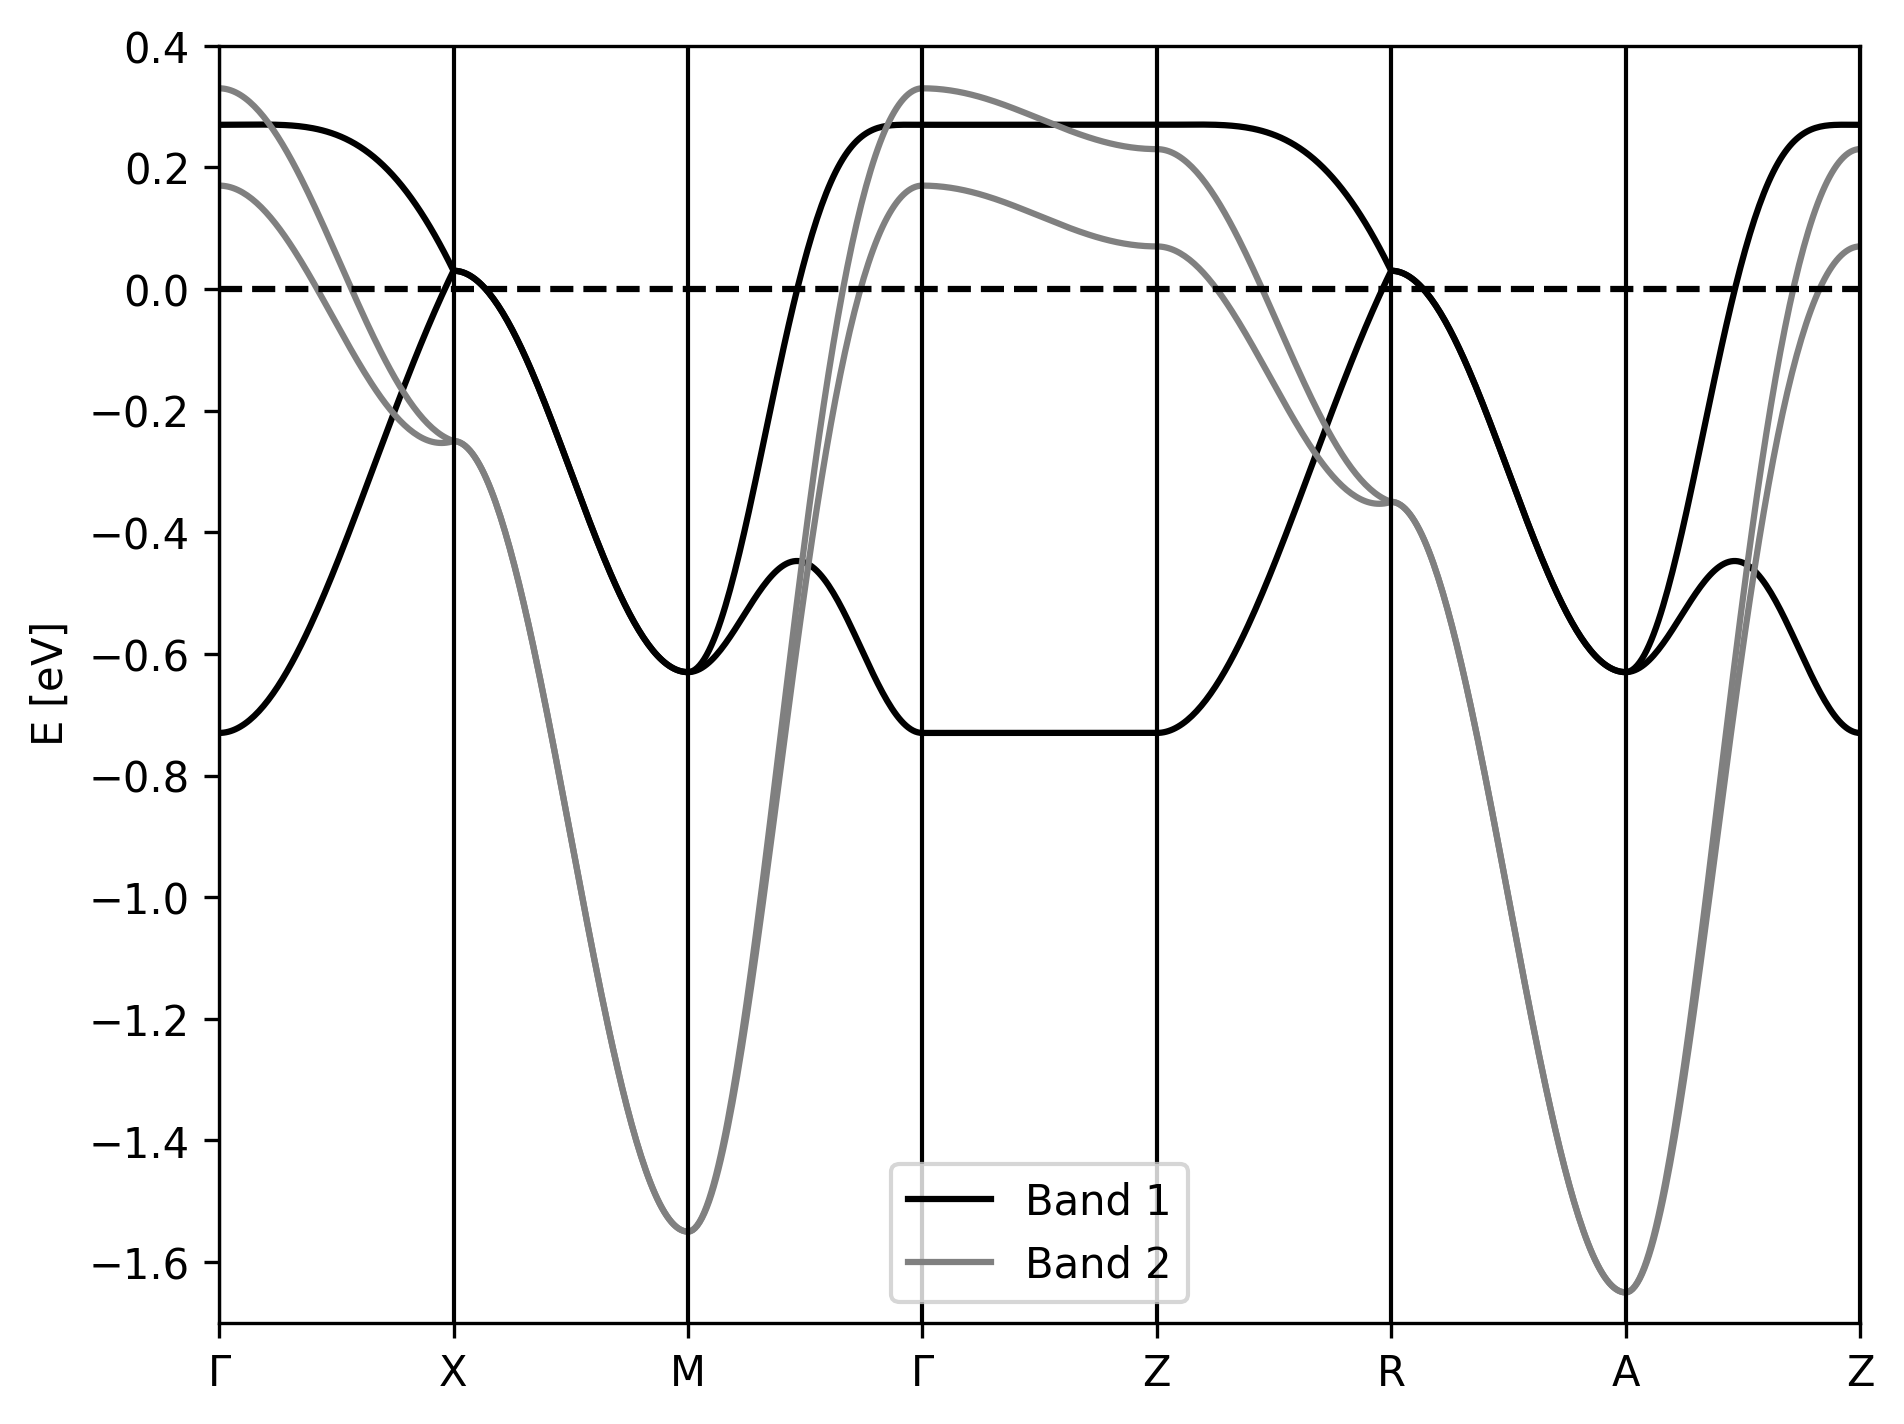

In [4]:
length = 100

tx0 = 0.5
t1 = 0.1
t2 = -0.23
t3 = 0
mu = 0.2

kxVector = np.concatenate((np.linspace(0,1,length,endpoint=False),np.ones(length),np.linspace(1,0,length,endpoint=False),np.zeros(length),np.linspace(0,1,length,endpoint=False),np.ones(length),np.linspace(1,0,length,endpoint=False)))
kyVector = np.concatenate((np.zeros(length),np.linspace(0,1,length,endpoint=False),np.linspace(1,0,length,endpoint=False),np.zeros(length),np.zeros(length),np.linspace(0,1,length,endpoint=False),np.linspace(1,0,length,endpoint=False)))
kzVector = np.concatenate((np.zeros(length),np.zeros(length),np.zeros(length),np.linspace(0,1,length,endpoint=False),np.ones(length),np.ones(length),np.ones(length)))

eigenValues1, eigenVectors1 = get2DEnergiesPath(kxVector,kyVector,kzVector,tx0,t1,t2,t3,mu)

tx0 = 0.08
t1 = 0.45
t2 = -0.2
t3 = 0.05
mu = 0.5

eigenValues2, eigenVectors2 = get2DEnergiesPath(kxVector,kyVector,kzVector,tx0,t1,t2,t3,mu)

np.savetxt(f'Fig4_1_N={length}_band1.txt', np.array([np.arange(0,7*length), eigenValues1[:,0], eigenValues1[:,1]]))
np.savetxt(f'Fig4_1_N={length}_band2.txt', np.array([np.arange(0,7*length), eigenValues2[:,0], eigenValues2[:,1]]))

fig, ax = plt.subplots(dpi=300)
plt.plot(np.arange(0,7*length),eigenValues1[:,0],'-',color='black',label='Band 1')
plt.plot(np.arange(0,7*length),eigenValues2[:,0],'-',color='gray',label='Band 2')
plt.plot(np.arange(0,7*length),eigenValues1[:,1],'-',color='black')
plt.plot(np.arange(0,7*length),eigenValues2[:,1],'-',color='gray')

plt.ylabel('E [$\\mathrm{eV}$]')

# Find the values for the ticks and labels
xticks = np.array([0,1,2,3,4,5,6,7])*length
xlabels=['$\\Gamma$', 'X', 'M', '$\\Gamma$','Z','R','A','Z']
ax.set_xticks(xticks, labels=xlabels)
yticks = np.array([-1.6,-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4])
ax.set_yticks(yticks)

for x in xticks:
    plt.axvline(x=x,color='black',linewidth=1)
plt.axhline(y=0,color='black',linestyle='--')

plt.tight_layout()
plt.xlim([0,7*length])
plt.ylim([-1.7,0.4])
plt.legend(loc='lower center')
# plt.savefig('EdelsteinFig1.png')
plt.savefig('EdelsteinFig1.pdf')
plt.show()
plt.close('all')

## Figure Part 2

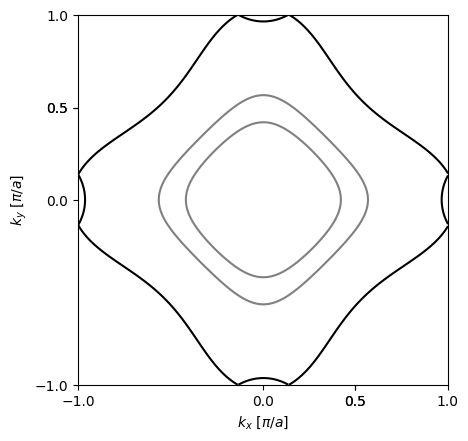

In [5]:
length = 500

tx0 = 0.5
t1 = 0.1
t2 = -0.23
t3 = 0
mu = 0.2

eigenValues1, eigenVectors1 = get2DSquareEnergies(length,tx0,t1,t2,t3,mu)

tx0 = 0.08
t1 = 0.45
t2 = -0.2
t3 = 0.05
mu = 0.5

eigenValues2, eigenVectors2 = get2DSquareEnergies(length,tx0,t1,t2,t3,mu)

createContourGraph(length,eigenValues1,eigenValues2,[0],filename='EdelsteinFig2')

## Figure Part 3

Done with the calculation of the bands and eigenvectors. -0.7320975524245502 0.2935518050344831
Done with the calculation of the bands and eigenvectors. -1.5512142193445007 0.3327402224885694
Done with the calculation of the bands and eigenvectors. -0.738340491299867 0.3335512694246
Done with the calculation of the bands and eigenvectors. -1.554889613293406 0.3408302232898693
Done with the calculation of the bands and eigenvectors. -0.7305207956972882 0.2747266617649529
Done with the calculation of the bands and eigenvectors. -1.5502921247806065 0.3306825293690769


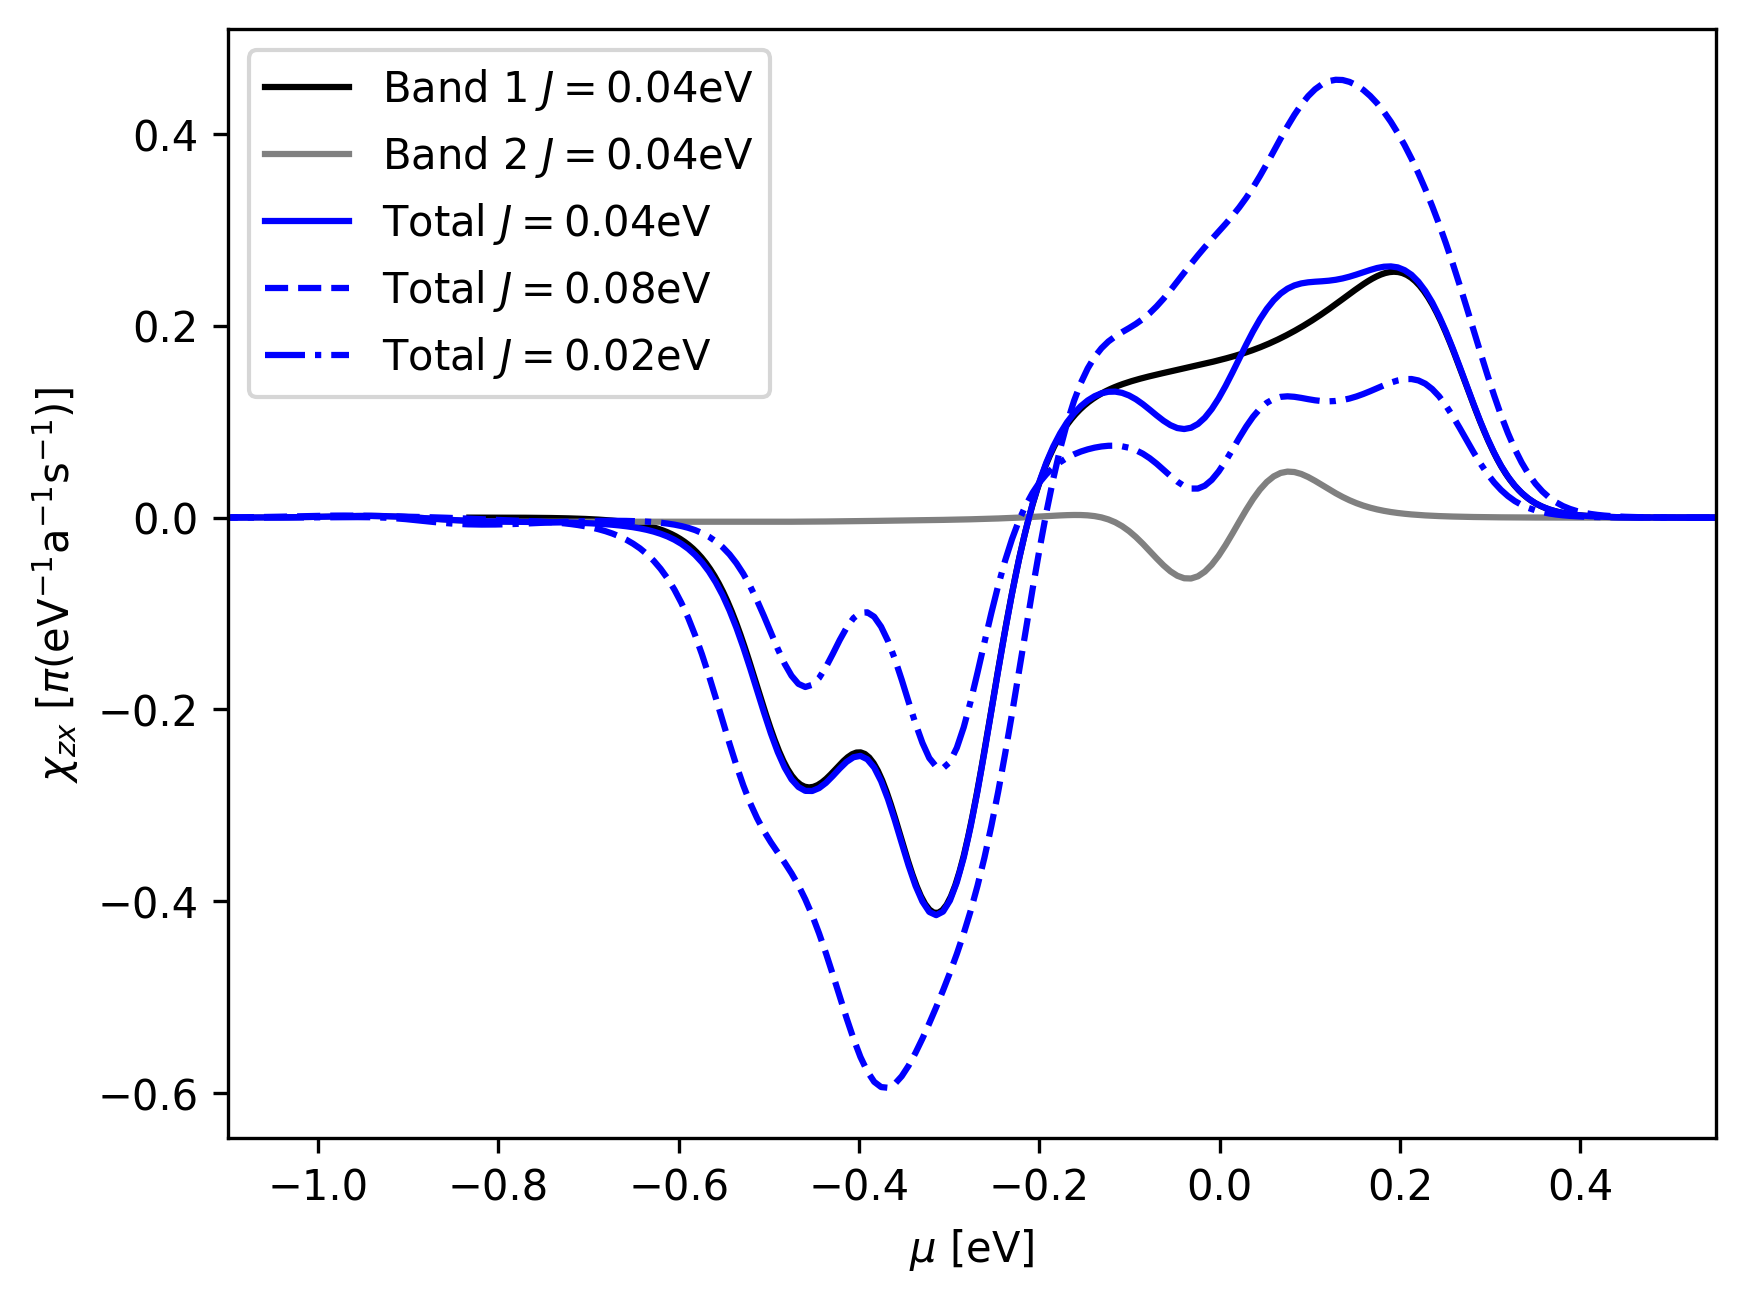

In [6]:
length = 500

tx01 = 0.5
t11 = 0.1
t21 = -0.23
t31 = 0
mu1 = 0.2

tx02 = 0.08
t12 = 0.45
t22 = -0.2
t32 = 0.05
mu2 = 0.5

#Temperature in eV
T = 300*boltzConst

J1 = 0.04
J2 = 0.08
J3 = 0.02

# do the calculation here (might take minutes to hours with high resolution)
chempotList11, edelsteinSusc11, edelsteinSusc1y1 = edelsteinNNNN(length, 300, tx01, t11, t21, t31, mu1, J1, Temperature = T)
chempotList21, edelsteinSusc21, edelsteinSusc2y1 = edelsteinNNNN(length, 300, tx02, t12, t22, t32, mu2, J1, Temperature = T)

chempotList12, edelsteinSusc12, edelsteinSusc1y2 = edelsteinNNNN(length, 300, tx01, t11, t21, t31, mu1, J2, Temperature = T)
chempotList22, edelsteinSusc22, edelsteinSusc2y2 = edelsteinNNNN(length, 300, tx02, t12, t22, t32, mu2, J2, Temperature = T)

chempotList13, edelsteinSusc13, edelsteinSusc1y3 = edelsteinNNNN(length, 300, tx01, t11, t21, t31, mu1, J3, Temperature = T)
chempotList23, edelsteinSusc23, edelsteinSusc2y3 = edelsteinNNNN(length, 300, tx02, t12, t22, t32, mu2, J3, Temperature = T)

#Finding the total Edelstein effect
edelsteinSusc11Interp = np.interp(chempotList21,chempotList11,edelsteinSusc11)
totalEdelstein1 = edelsteinSusc11Interp + edelsteinSusc21
edelsteinSusc12Interp = np.interp(chempotList22,chempotList12,edelsteinSusc12)
totalEdelstein2 = edelsteinSusc12Interp + edelsteinSusc22
edelsteinSusc13Interp = np.interp(chempotList23,chempotList13,edelsteinSusc13)
totalEdelstein3 = edelsteinSusc13Interp + edelsteinSusc23
edelsteinSusc1y1Interp = np.interp(chempotList21,chempotList11,edelsteinSusc1y1)
totalEdelstein1y = edelsteinSusc1y1Interp + edelsteinSusc2y1
edelsteinSusc1y2Interp = np.interp(chempotList22,chempotList12,edelsteinSusc1y2)
totalEdelstein2y = edelsteinSusc1y2Interp + edelsteinSusc2y2
edelsteinSusc1y3Interp = np.interp(chempotList23,chempotList13,edelsteinSusc1y3)
totalEdelstein3y = edelsteinSusc1y3Interp + edelsteinSusc2y3

# save the result in file

np.savetxt(f'Fig4_3_N={length}_004_band1.txt', np.array([chempotList11, edelsteinSusc11, edelsteinSusc1y1]))
np.savetxt(f'Fig4_3_N={length}_004_band2.txt', np.array([chempotList21, edelsteinSusc21, edelsteinSusc2y1]))
np.savetxt(f'Fig4_3_N={length}_004_full.txt', np.array([chempotList21, totalEdelstein1, totalEdelstein1y]))
np.savetxt(f'Fig4_3_N={length}_008_full.txt', np.array([chempotList21, totalEdelstein2, totalEdelstein2y]))
np.savetxt(f'Fig4_3_N={length}_002_full.txt', np.array([chempotList21, totalEdelstein3, totalEdelstein3y]))

# read in the file from disk and

# do the plotting separately


plt.figure(dpi=300)
plt.plot(chempotList11,edelsteinSusc11,c='black',label=f'Band 1 $J = {round(J1,4)}$eV')
plt.plot(chempotList21,edelsteinSusc21,c='grey',label=f'Band 2 $J = {round(J1,4)}$eV')
plt.plot(chempotList21,totalEdelstein1,c='blue',label=f'Total $J = {round(J1,4)}$eV')
plt.plot(chempotList21,totalEdelstein2,c='blue',linestyle='--',label=f'Total $J = {round(J2,4)}$eV')
plt.plot(chempotList21,totalEdelstein3,c='blue',linestyle='dashdot',label=f'Total $J = {round(J3,4)}$eV')
plt.legend()
plt.xlabel('$\\mu$ [$\\mathrm{eV}$]')
plt.ylabel('$\\chi_{zx}$ [$\\pi (\\mathrm{eV^{-1}a^{-1}s^{-1}})$]')
plt.xlim([-1.1,0.55])
#plt.savefig('EdelsteinFig3.png')
plt.savefig('EdelsteinFig3.pdf')

## Figure Part 4

No contour found for band  1
No contour found for band  2
No contour found for band  1
No contour found for band  2
No contour found for band  3
No contour found for band  4


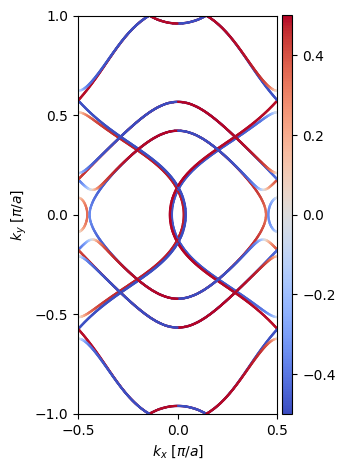

In [7]:
length = 500
length2 = int(length/2)

# This is problematic: You use two different setups of the k-grid: the one here and the one in getSpinZ.
# for plotting we want to have +pi and -pi in the grid to make it look symmetric, for calculation we do not want
# the boundaries
kxVector1D = np.linspace(-0.5,0.5,length2,endpoint=False) + 1/(2*(length2+1))
kyVector1D = np.linspace(-1,1,length,endpoint=False) + 1/(2*(length+1))
kx,ky = np.meshgrid(kxVector1D,kyVector1D,indexing='ij')

tx01 = 0.5
t11 = 0.1
t21 = -0.23
t31 = 0
mu1 = 0.2

tx02 = 0.08
t12 = 0.45
t22 = -0.2
t32 = 0.05
mu2 = 0.5

J = 0.04

spin, eigVals1, *_ = getSpinZ(length,length2,tx01,t11,t21,t31,mu1,J)
spin, eigVals2, *_ = getSpinZ(length,length2,tx02,t12,t22,t32,mu2,J)

# here still some technical problem: Why are the dots not "dark blue" and "dark red"?
createContourSpinGraph(kxVector1D,kyVector1D,eigVals1,eigVals2,tx01,t11,t21,t31,mu1,tx02,t12,t22,t32,mu2, J, [0],length,filename='EdelsteinFig4')